In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from gradcam import make_gradcam_heatmap, get_last_conv_layer

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

metadata = pd.read_csv('../data/HAM10000_metadata.csv')
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
metadata.info()

metadata.describe()

metadata.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

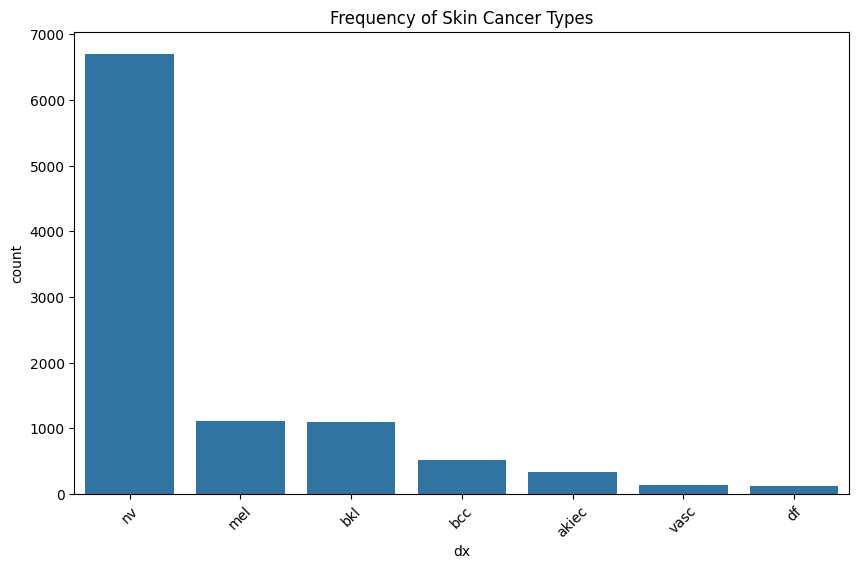

In [4]:
plt.figure(figsize=(10,6))
sns.countplot(x='dx', data=metadata, order=metadata['dx'].value_counts().index)
plt.title('Frequency of Skin Cancer Types')
plt.xticks(rotation=45)
plt.show()


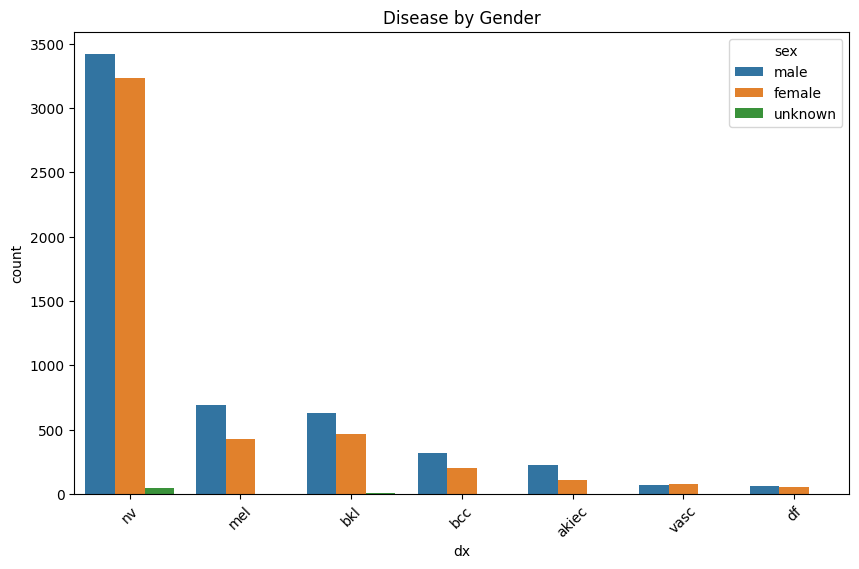

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(x='dx', hue='sex', data=metadata, order=metadata['dx'].value_counts().index)
plt.title('Disease by Gender')
plt.xticks(rotation=45)
plt.show()

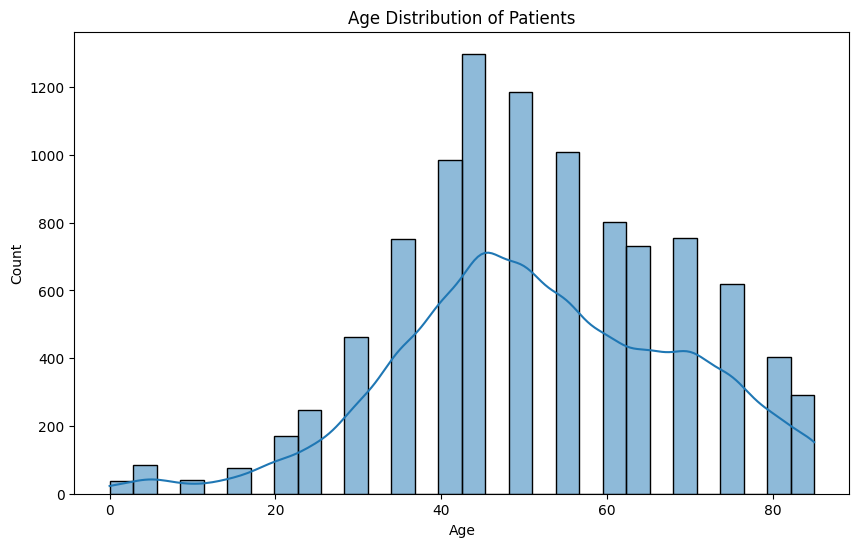

In [6]:
plt.figure(figsize=(10,6))
sns.histplot(metadata['age'], bins=30, kde=True)
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.show()


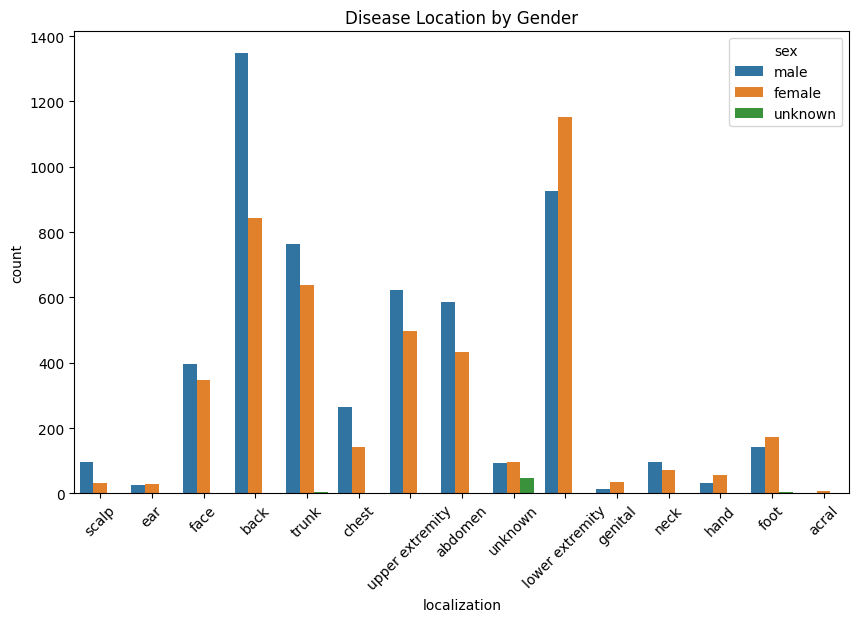

In [7]:
plt.figure(figsize=(10,6))
sns.countplot(x='localization', hue='sex', data=metadata)
plt.title('Disease Location by Gender')
plt.xticks(rotation=45)
plt.show()


In [ ]:
import os
metadata['image_path'] = metadata['image_id'].apply(
    lambda x: os.path.join('../data/all_images', f'{x}.jpg')
)
metadata[['image_id', 'image_path']].head()

,image_id,image_path
0,ISIC_0027419,../data/all_images\ISIC_0027419.jpg
1,ISIC_0025030,../data/all_images\ISIC_0025030.jpg
2,ISIC_0026769,../data/all_images\ISIC_0026769.jpg
3,ISIC_0025661,../data/all_images\ISIC_0025661.jpg
4,ISIC_0031633,../data/all_images\ISIC_0031633.jpg


In [ ]:
from sklearn.utils import resample

max_size = metadata['dx'].value_counts().max()

df_list = []
for label in metadata['dx'].unique():
    subset = metadata[metadata['dx'] == label]
    upsampled = resample(subset, replace=True, n_samples=max_size, random_state=42)
    df_list.append(upsampled)

balanced_metadata = pd.concat(df_list)

balanced_metadata['dx'].value_counts()

dx
bkl      6705
nv       6705
df       6705
mel      6705
vasc     6705
bcc      6705
akiec    6705
Name: count, dtype: int64

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

IMG_SIZE = 100

def preprocess_image(path):
    try:
        img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img = img_to_array(img) / 255.0 
        return img
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return np.zeros((IMG_SIZE, IMG_SIZE, 3))

X = np.array([preprocess_image(path) for path in balanced_metadata['image_path']])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(balanced_metadata['dx'])
y_cat = to_categorical(y)


In [11]:
print("X shape:", X.shape)
print("y_cat shape:", y_cat.shape)

X shape: (46935, 100, 100, 3)
y_cat shape: (46935, 7)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 37548
Testing samples: 9387


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32
)


d:\Python\Projects\SkinCancerCnnPrediction\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 298s 277ms/step - accuracy: 0.4297 - loss: 1.4768 - val_accuracy: 0.7976 - val_loss: 0.5866
Epoch 2/10
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 273s 258ms/step - accuracy: 0.7706 - loss: 0.6325 - val_accuracy: 0.9001 - val_loss: 0.2736
Epoch 3/10
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 300s 284ms/step - accuracy: 0.8628 - loss: 0.3696 - val_accuracy: 0.9270 - val_loss: 0.2103
Epoch 4/10
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 272s 257ms/step - accuracy: 0.9082 - loss: 0.2539 - val_accuracy: 0.9438 - val_loss: 0.1743
Epoch 5/10
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 282s 266ms/step - accuracy: 0.9267 - loss: 0.2035 - val_accuracy: 0.9680 - val_loss: 0.1015
Epoch 6/10
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 276s 261ms/step - accuracy: 0.9407 - loss: 0.1600 - val_accuracy: 0.9680 - val_loss: 0.0996
Epoch 7/10
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 276s 261ms/step - accuracy: 0.9421 - loss: 0.1584 - val_accuracy: 0.9742 - val_loss: 0.0867
Epoch 8/10
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 279s 264ms/step - ac

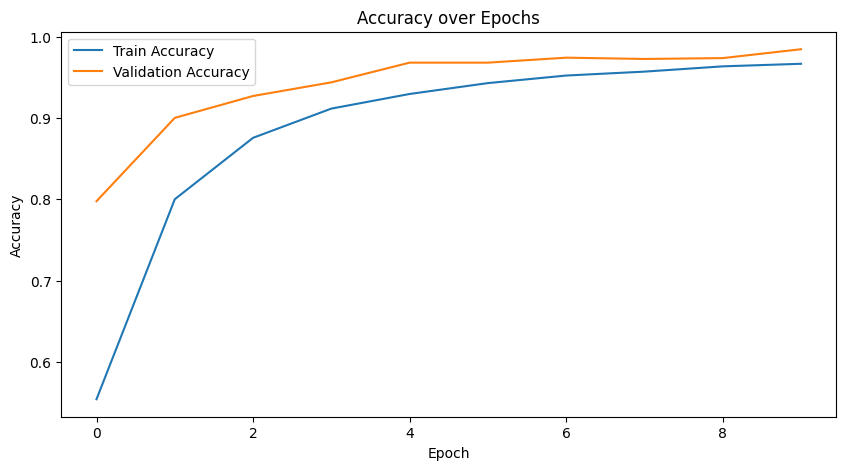

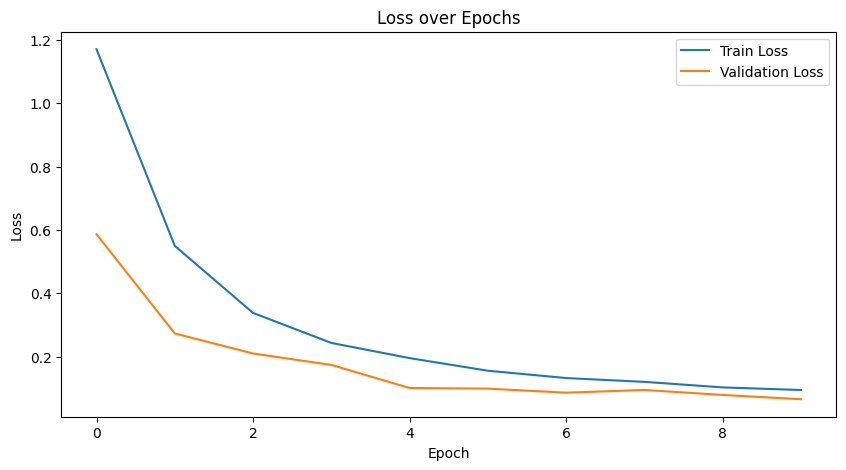

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"🧪 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


294/294 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9832 - loss: 0.0766
🧪 Test Accuracy: 98.35%
📉 Test Loss: 0.0706


In [ ]:
model.save('../models/skin_cancer_cnn.h5')
print("✅ Model saved to ../models/skin_cancer_cnn.h5")


✅ Model saved to ../models/skin_cancer_cnn.h5


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D

def get_last_conv_layer_name(model):
    """
    Finds the name of the last Conv2D layer in the model.
    """
    for layer in reversed(model.layers):
        if isinstance(layer, Conv2D):
            return layer.name
        
        if hasattr(layer, "layers"):
            for sub_layer in reversed(layer.layers):
                if isinstance(sub_layer, Conv2D):
                    return sub_layer.name
    raise ValueError("No Conv2D layer found in the model.")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    target_layer = None
    for layer in model.layers:
        if layer.name == last_conv_layer_name:
            target_layer = layer
            break
        if hasattr(layer, "layers"):
            for sub_layer in layer.layers:
                if sub_layer.name == last_conv_layer_name:
                    target_layer = sub_layer
                    break

    if target_layer is None:
        raise ValueError(f"Layer '{last_conv_layer_name}' not found in model.")

    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[target_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-8)

    return heatmap.numpy()


Model: "functional_178"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 7)              │     4,353,991 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353,991 (16.61 MB)

 Trainable params: 4,353,991 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
✅ Predicted class index: 4, Confidence: 99.17%
✅ Heatmap shape: (47, 47)


C:\Users\fbr96\AppData\Local\Temp\ipykernel_6244\1191466257.py:124: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\fbr96\AppData\Local\Temp\ipykernel_6244\1191466257.py:124: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\fbr96\AppData\Local\Temp\ipykernel_6244\1191466257.py:124: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Python\Projects\SkinCancerCnnPrediction\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Python\Projects\SkinCancerCnnPrediction\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Python\Projects\SkinCancerCnnPrediction\venv\Lib\site-packages\IPy

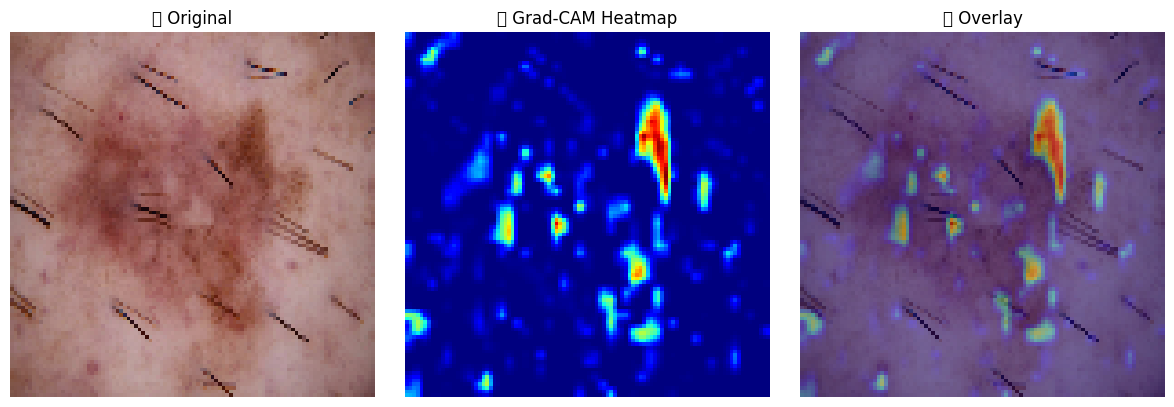

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from PIL import Image
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input


seq_model = load_model("../models/skin_cancer_cnn.h5")

inputs = Input(shape=(100, 100, 3))
outputs = seq_model(inputs)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

def get_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
        elif hasattr(layer, "layers"): 
            for sub_layer in reversed(layer.layers):
                if isinstance(sub_layer, tf.keras.layers.Conv2D):
                    return sub_layer.name
    raise ValueError("No Conv2D layer found in the model.")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    seq_model = model.get_layer("sequential")
    
    last_conv_layer = seq_model.get_layer(last_conv_layer_name)

    inputs = model.input
    x = inputs
    for layer in seq_model.layers:
        x = layer(x)
        if layer.name == last_conv_layer_name:
            conv_output = x

    predictions = x 
    grad_model = tf.keras.Model(inputs=inputs, outputs=[conv_output, predictions])

    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)

    max_val = tf.reduce_max(heatmap)
    if max_val == 0:
        return np.zeros_like(heatmap)

    heatmap /= max_val
    return heatmap.numpy()


img_path = "../data/all_images/ISIC_0024323.jpg"
img_pil = Image.open(img_path).resize((100, 100)).convert("RGB")
img_array = img_to_array(img_pil) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
pred_index = np.argmax(prediction[0])
confidence = prediction[0][pred_index] * 100
print(f"✅ Predicted class index: {pred_index}, Confidence: {confidence:.2f}%")

last_conv_layer_name = get_last_conv_layer_name(model)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index)
print("✅ Heatmap shape:", heatmap.shape)

img_cv = cv2.imread(img_path)
img_cv = cv2.resize(img_cv, (100, 100))
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

heatmap_resized = cv2.resize(heatmap, (img_rgb.shape[1], img_rgb.shape[0]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap_colored, 0.4, 0)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("🖼️ Original")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("🔥 Grad-CAM Heatmap")
plt.imshow(heatmap_resized, cmap="jet")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("🧠 Overlay")
plt.imshow(superimposed_img)
plt.axis("off")

plt.tight_layout()
plt.show()
